In [1]:
import pandas as pd
import os
import numpy as np
import json
from scipy.stats import iqr
import matplotlib.pyplot as plt

In [7]:
# Definiere die relevanten Stats (Spaltennamen in deiner CSV):
relevant_stats = [
    "total_kills",
    "total_deaths",
    "total_time_played",
    "total_wins",
    "total_kills_headshot",
    "total_shots_hit",
    "total_shots_fired",
    "total_rounds_played",
    "total_matches_won",
    "total_matches_played",
    "total_gg_matches_won",
    "total_gg_matches_played",
    #"stat_player_deaths"
]

# Pfad zu deiner CSV-Datei
csv_file = "730_stats_Counter-Strike_2.csv"
app_id = 730
name = "Counter-Strike_2"

# DataFrame einlesen
df = pd.read_csv(csv_file)

In [8]:
# -------------------------------
# 3) Wichtige Spielstatistiken berechnen
# -------------------------------

# K/D-Ratio berechnen
if "total_kills" in df.columns and "total_deaths" in df.columns:
    df["KD_ratio"] = df["total_kills"] / df["total_deaths"]
    df["KD_ratio"] = df["KD_ratio"].replace([np.inf, -np.inf], np.nan)  # Inf-Werte durch NaN ersetzen
    relevant_stats.append("KD_ratio")  # Füge die K/D-Statistik zur Analyse hinzu

# Trefferquote berechnen
if "total_shots_fired" in df.columns and "total_shots_hit" in df.columns:
    df["accuracy"] = (df["total_shots_hit"] / df["total_shots_fired"]) * 100
    df["accuracy"] = df["accuracy"].clip(0,100)
    relevant_stats.append("accuracy")

# Headshot-Quote berechnen
if "total_kills_headshot" in df.columns and "total_shots_hit" in df.columns:
    df["headshot_ratio"] = (df["total_kills_headshot"] / df["total_shots_hit"]) * 100
    df["headshot_ratio"] = df["headshot_ratio"].clip(0,100)
    relevant_stats.append("headshot_ratio")

# Siegesquote berechnen
if "total_matches_won" in df.columns and "total_matches_played" in df.columns:
    df["win_ratio"] = (df["total_matches_won"] / df["total_matches_played"]) * 100
    df["win_ratio"] = df["win_ratio"].clip(0,100)
    relevant_stats.append("win_ratio")

# -------------------------------
# Min/Max Werte berechnen
# -------------------------------
kd_min = df["KD_ratio"].min()
kd_max = df["KD_ratio"].max()

accuracy_min = df["accuracy"].min()
accuracy_max = df["accuracy"].max()

headshot_ratio_min = df["headshot_ratio"].min()
headshot_ratio_max = df["headshot_ratio"].max()

win_ratio_min = df["win_ratio"].min()
win_ratio_max = df["win_ratio"].max()

# Ergebnisse ausgeben
print(f"Minimale K/D-Ratio: {kd_min:.2f} | Maximale K/D-Ratio: {kd_max:.2f}")
print(f"Minimale Trefferquote: {accuracy_min:.2f}% | Maximale Trefferquote: {accuracy_max:.2f}%")
print(f"Minimale Headshot-Quote: {headshot_ratio_min:.2f}% | Maximale Headshot-Quote: {headshot_ratio_max:.2f}%")
print(f"Minimale Siegesquote: {win_ratio_min:.2f}% | Maximale Siegesquote: {win_ratio_max:.2f}%")


Minimale K/D-Ratio: 0.00 | Maximale K/D-Ratio: 30021.96
Minimale Trefferquote: 0.00% | Maximale Trefferquote: 100.00%
Minimale Headshot-Quote: 0.00% | Maximale Headshot-Quote: 100.00%
Minimale Siegesquote: 0.15% | Maximale Siegesquote: 100.00%


In [22]:
# -------------------------------
# 4) FUNKTIONEN FÜR IQR-BEREINIGUNG UND PERZENTILE
# -------------------------------
def remove_outliers_iqr(series):
    """
    Entfernt Ausreißer mithilfe des Interquartilsabstands (IQR).
    Gibt die bereinigte Series und die Anzahl der entfernten Werte zurück.
    """
    data = series.dropna().to_numpy()
    if len(data) < 4:
        return series, 0  # Keine Werte oder zu wenige für IQR-Berechnung

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr_value = iqr(data)
    print(q1)
    print(q3)
    print(iqr_value)
    lower_bound = q1 - 3 * iqr_value
    upper_bound = q3 + 3 * iqr_value
    
    # Maske der Werte, die im akzeptablen Bereich liegen
    mask = (series >= lower_bound) & (series <= upper_bound)
    removed_count = (~mask).sum()
    cleaned_series = series[mask]
    
    return cleaned_series, removed_count

In [23]:
#Perzentile berechnen und Ausreißer entfernen
def calculate_percentiles(values, ptiles = [i for i in range(100)]):
    """
    Berechnet die angegebenen Perzentile für eine gegebene Werte-Serie.
    """
    result = {}
    data = values.dropna().to_numpy()
    for p in ptiles:
        result[f"{p}%"] = np.percentile(data, p)
    return result

# -------------------------------
# 5) AUSWERTUNG PRO SPALTE
# -------------------------------
results = {}         # Perzentil-Ergebnisse pro Statistik
exclusion_stats = {} # Daten zum Ausschluss (Anzahl/Werte)

for stat in relevant_stats:
    if stat not in df.columns:
        continue  # Falls Spalte fehlt
    
    series = df[stat].dropna()
    if series.empty:
        continue
    
    # Ausreißer entfernen
    cleaned_series, removed_count = remove_outliers_iqr(series)
    original_count = len(series)
    cleaned_count = len(cleaned_series)
    
    if cleaned_count == 0:
        continue  # Alles wurde entfernt
    
    # Perzentile berechnen
    stat_percentiles = calculate_percentiles(cleaned_series)
    
    # Ergebnisse ablegen
    results[stat] = stat_percentiles
    exclusion_stats[stat] = {
        "original_count": original_count,
        "cleaned_count": cleaned_count,
        "removed_count": removed_count,
        "percent_excluded": (removed_count / original_count) * 100
    }

1893.0
34124.0
32231.0
1897.25
33210.25
31313.0
123870.5
2361787.0
2237916.5
744.0
15682.0
14938.0
643.5
12960.25
12316.75
5808.5
106786.5
100978.0
37149.0
609250.0
572101.0
1403.5
30896.25
29492.75
54.0
746.0
692.0
130.0
1735.75
1605.75
2.0
26.0
24.0
21.0
311.0
290.0
0.8349673695488615
1.1545017568980622
0.3195343873492007
14.128043229777152
19.439165641156386
5.311122411379234
8.898147862108306
15.462673970480042
6.5645261083717354
36.430644443872616
47.587737624004305
11.157093180131689


Die zusammengefassten Perzentile wurden in 730_statistische_auswertung.csv gespeichert.
0.8349673695488615
1.1545017568980622
0.3195343873492007


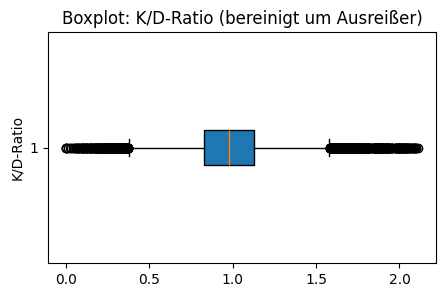

In [24]:
# -------------------------------
# 6) ERGEBNISSE IN CSV SCHREIBEN
# -------------------------------
rows_for_csv = []

for stat, stat_percentiles in results.items():
    row = {
        "stat": stat,
        "original_count": exclusion_stats[stat]["original_count"],
        "cleaned_count": exclusion_stats[stat]["cleaned_count"],
        "removed_count": exclusion_stats[stat]["removed_count"],
        "percent_excluded": exclusion_stats[stat]["percent_excluded"]
    }
    # Perzentile anhängen
    for p_label, p_value in stat_percentiles.items():
        row[p_label] = p_value
    
    rows_for_csv.append(row)

# DataFrame aus den Auswertungsergebnissen
results_df = pd.DataFrame(rows_for_csv)
results_df.to_csv(rf"C:\Users\paulu\OneDrive\Desktop\WebMining_final\Dashboard\{app_id}_statistische_auswertung.csv", index=False)
print(f"Die zusammengefassten Perzentile wurden in {app_id}_statistische_auswertung.csv gespeichert.")

# -------------------------------
# 7) BEISPIEL: BOX PLOT FÜR "KD_ratio"
# -------------------------------
if "KD_ratio" in df.columns:
    # Daten erneut aus "df" nehmen
    # und die IQR-Bereinigung anwenden (damit der Boxplot ohne Ausreißer gemalt wird)
    kd_series = df["KD_ratio"].dropna()
    cleaned_series_kd, _ = remove_outliers_iqr(kd_series)
    
    # Matplotlib-Boxplot zeichnen
    plt.figure(figsize=(5, 3))
    plt.boxplot(cleaned_series_kd, vert=False, patch_artist=True)
    plt.title("Boxplot: K/D-Ratio (bereinigt um Ausreißer)")
    plt.ylabel("K/D-Ratio")
    plt.show()


In [18]:
#display all max and min values as well as the difference between them
for stat in relevant_stats:
    print(f"Statistik: {stat}")
    print(f"  Max: {df[stat].max()}")
    print(f"  Min: {df[stat].min()}")
    print(f"  Difference: {df[stat].max() - df[stat].min()}")
    print()

Statistik: total_kills
  Max: 1000001355.0
  Min: 0.0
  Difference: 1000001355.0

Statistik: total_deaths
  Max: 100017938.0
  Min: 0.0
  Difference: 100017938.0

Statistik: total_time_played
  Max: 2036165379.0
  Min: 0.0
  Difference: 2036165379.0

Statistik: total_wins
  Max: 1000000866.0
  Min: 0.0
  Difference: 1000000866.0

Statistik: total_kills_headshot
  Max: 1000000711.0
  Min: 0.0
  Difference: 1000000711.0

Statistik: total_shots_hit
  Max: 1000003469.0
  Min: 0.0
  Difference: 1000003469.0

Statistik: total_shots_fired
  Max: 1000008962.0
  Min: 0.0
  Difference: 1000008962.0

Statistik: total_rounds_played
  Max: 1000001876.0
  Min: 0.0
  Difference: 1000001876.0

Statistik: total_matches_won
  Max: 100000465.0
  Min: 0.0
  Difference: 100000465.0

Statistik: total_matches_played
  Max: 100000934.0
  Min: 0.0
  Difference: 100000934.0

Statistik: total_gg_matches_won
  Max: 15015.0
  Min: 0.0
  Difference: 15015.0

Statistik: total_gg_matches_played
  Max: 15323.0
  Min: 